# Example Use of MIRAGE to generate OTE Commissioning Images
---

In this notebook, we will go through the steps to use the MIRAGE (Multi-Instrument Ramp Generator) to simulate NIRCam images from OTE Commissioning.

There are a number of steps that must be taken to set up the simulator to process commissioning input. Once that setup is complete, however, the simulator is broken up into three basic stages:

1. **Creation of a "seed image".**<br>
    This is generally a noiseless countrate image that contains signal
   only from the astronomical sources to be simulated. Currently, the 
   nircam_simulator package contains code to produce a seed image starting
   from object catalogs.
   
2. **Dark current prep.**<br>
    The simualted data will be created by adding the simulated sources
   in the seed image to a real NIRCam dark current exposure. This step
   converts the dark current exposure to the requested readout pattern
   and subarray size requested by the user.
   
3. **Observation generator.**<br>
    This step converts the seed image into an exposure of the requested
   readout pattern and subarray size. It also adds cosmic rays and 
   Poisson noise, as well as other detector effects (IPC, crosstalk, etc).
   This exposure is then added to the dark current exposure from step 2.

<div class="alert alert-block alert-warning">
**Note:** <br>
You must have installed the `mirage` package before running this notebook. Install it using the following command while in the `mirage` repository (where the `setup.py` file is located):<br><br>

```
pip install -e .
```

</div>

In [1]:
# Standard Library Imports
import os
import re

# Third Party Imports
import pprint
import shutil
import jwxml
import yaml
from glob import glob
import numpy as np
# import webbpsf
from astropy.io import fits
from astropy.io import ascii as asc
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.vizier import Vizier
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

# Local Imports (from nircam_simulator package)
from mirage.scripts import catalog_seed_image
from mirage.scripts import dark_prep
from mirage.scripts import obs_generator
from mirage.scripts import imaging_simulator
from mirage.scripts import apt_inputs, yaml_generator 
from mirage.scripts import write_observationlist
from mirage.scripts import get_catalog

# View matplotlib plots inline
%matplotlib inline

ImportError: No module named 'jwxml'

In [7]:
# Define the location of this file (the examples/ directory)
__location__ = os.getcwd()

For this example we will simulate images from OTE-06: Segment Image Array. In this stage of commissioning, the mirrors are being moved to place the 18 segments in a hexagonal image array for the first time.

You can load this file in APT by selecting `File > Retrieve from STScI > Retrieve Using Proposal ID` and then entering 1140.
(You must be running APT in STScI mode for this retrieval method to be available.)

## Export APT files

Export the `.pointing` and `.xml` files for proposal 1140 in APT by selecting `File > Export...` and selecting both the xml and pointing file options. Save them in a place you will remember, naming them something descriptive such as `OTE06_1140.pointing`.

(Sample versions of both of these files are located within the `examples/` directory.)

## Define the location of APT files

In [27]:
prop_id = 1140

# Change if you put your files somewhere else
ote_dir = os.path.join(__location__, 'ote_data')

# Change if you named your files differently.
root = 'OTE06-{}'.format(prop_id)

pointing_file = os.path.join(ote_dir, root + '.pointing')
xml_file = os.path.join(ote_dir, root + '.xml')

## Query online catalogs to generate catalog files of sources in FOV

Next, we need to generate catalog files for the sources around the target in this proposal. First we must parse the pointing file to determine the RA and Dec of the target (or targets) that will be observed. Then we will query 2MASS and WISE to get the magnitudes and locations of shortwave and longwave sources, respectively, around the target.

All of this can be accomplished with the `get_catalog.get_all_catalogs` function.

These catalog files will be written to the `mirage/catalogs/` directory. If files for a given catalog and RA/Dec have already been generated, they will not be regenerated.

<div class="alert alert-block alert-warning">
**Important:** <br>
Querying 2MASS and WISE is only appropriate for observations with the F212N and F480M NIRCam filters. If you want to simulate observations that use other filters, you will have to either query different bandpasses or catalogs or perform a photometric conversion on an existing catalog.

</div>

In [28]:
# Get SW and LW catalogs
cats = get_catalog.get_all_catalogs(pointing_file, prop_id)
target_coords, catalog_filenames_sw, catalog_filenames_lw = cats

Target coordinates:  146.87731 63.24781
Queried 366 2MASS objects within 15.0 arcmin of RA, Dec (146.88, 63.25).
Successfully saved shortwave catalog to /Users/lchambers/TEL/nircam_simulator/nircam_simulator/catalogs/2MASS_RA146.88deg_Dec63.25deg.list.
Queried 3145 WISE objects within 15.0 arcmin of RA, Dec (146.88, 63.25).
Successfully saved longwave catalog to /Users/lchambers/TEL/nircam_simulator/nircam_simulator/catalogs/WISE_RA146.88deg_Dec63.25deg.list.


# Plot all sources in catalogs

Let's see how many sources we're dealing with here.

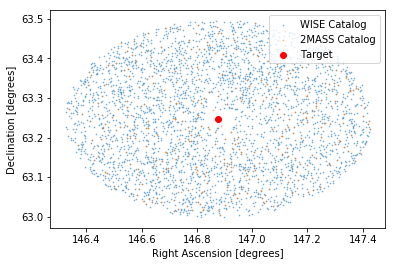

In [29]:
# Plot all queried sources
target_catalog_lw = asc.read(catalog_filenames_lw[0])
target_catalog_sw = asc.read(catalog_filenames_sw[0])
plt.scatter(target_catalog_lw['x_or_RA'], target_catalog_lw['y_or_Dec'], label = 'WISE Catalog', s=.5, alpha=.5)
plt.scatter(target_catalog_sw['x_or_RA'], target_catalog_sw['y_or_Dec'], label = '2MASS Catalog', s=.5, alpha=.5)
plt.scatter(target_coords[0].ra.degree, target_coords[0].dec.degree, label='Target', c='r')
plt.xlabel('Right Ascension [degrees]')
plt.ylabel('Declination [degrees]')
plt.legend()
plt.show()

# Create YAML files from APT files

Now we can start the simulation process.

First we have to generate an `observationlist.yaml` file from the APT files we exported. This file contains a list of the different observations in the given APT proposal, as well as the filter configurations for each of those observations and the associated catalog files (that we just generated in the previous step).

The `observationlist.yaml` file is very important for cases where one observation uses multiple different filters, and thus needs to source multiple different catalog files. In such cases the `yaml` file would need to be generated manually. However, in this example, there is only one filter needed for each observation, and so we can use the `write_observationlist` module to generate a file.

You will find the generated file in the directory you defined as `ote_dir`.

In [58]:
# Create observation table file from APT files
observationlist_file = os.path.join(os.getcwd(), ote_dir, root + '_observationlist.yaml')
write_observationlist.write_yaml(xml_file, pointing_file, observationlist_file, 
                                 ps_cat_sw=catalog_filenames_sw, ps_cat_lw=catalog_filenames_lw)

Found 19 exposure(s) for observation 1 (Form medium array)
Found 19 exposure(s) for observation 2 (Clean up or form large array)
Found 19 exposure(s) for observation 3 (Form large array or clean up)
Found 19 exposure(s) for observation 4 (Clean up large array)
Found 19 exposure(s) for observation 5 (Clean up large array)
Found 4 exposure(s) for observation 6 (NIRCam Image Segments)

Successfully wrote 6 observations to /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/OTE06-1140_observationlist.yaml


Next, the simulator uses that `observationlist.yaml` to generate a `yaml` file for every single exposure in the proposal.

This step can take a while. Once it is done, you will see a ton of (135, to be exact) `yaml` files appear in the `ote_dir`, as well as an exposure table `expand_for_detectors.csv` and an observation table `Observation_table*.xml` that both list every image taken with all used detectors.

In [59]:
# Create a series of data simulator input yaml files from APT files
yam = yaml_generator.SimInput()

yam.input_xml = xml_file
yam.pointing_file = pointing_file
siaf_file = os.path.expandvars('$MIRAGE_DATA/nircam/reference_files/SIAF/NIRCam_SIAF_2018-01-08.csv')
yam.siaf = siaf_file
yam.output_dir = os.path.join(os.getcwd(), ote_dir)
yam.simdata_output_dir = os.path.join(os.getcwd(), ote_dir)
yam.observation_table = observationlist_file

yam.use_JWST_pipeline = False # changed to False
yam.use_linearized_darks = True # changed to True
yam.datatype = 'linear'

yam.reffile_setup()
yam.create_inputs()

Using /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/OTE06-1140_observationlist.yaml, 
      /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/OTE06-1140.xml, 
      /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/OTE06-1140.pointing, and 
      /ifs/jwst/wit/witserv/data4/nrc/hilbert/simulated_data/NIRCam_SIAF_2017-03-28.csv 
      to generate observation table.

Found 19 exposure(s) for observation 1 (Form medium array)
Found 19 exposure(s) for observation 2 (Clean up or form large array)
Found 19 exposure(s) for observation 3 (Form large array or clean up)
Found 19 exposure(s) for observation 4 (Clean up large array)
Found 19 exposure(s) for observation 5 (Clean up large array)
Found 4 exposure(s) for observation 6 (NIRCam Image Segments)
Wrote exposure table to /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/expand_for_detectors.csv
Final csv exposure list written to /Users/lchambers/

In [60]:
# Print information about the yaml files that were generated.

yfiles = glob(os.path.join(ote_dir, 'V*yaml'))

obs_numbers = [f.split('/')[-1].split('_')[0] for f in yfiles]
all_obs_numbers = list(set(obs_numbers))
all_obs_numbers.sort()

n_obs = len(set([int(number[9:11]) for number in all_obs_numbers]))

print('Found {} yaml files.'.format(len(obs_numbers)))
print('({} exposures across {} observations)'.format(len(all_obs_numbers), n_obs))
# pprint.pprint(all_obs_numbers)

Found 135 yaml files.
(99 exposures across 6 observations)


# Choose which yaml (visit/tile) to use

At the moment, we can only generate one image at a time, so even though we have 135 yaml files in our `ote_dir` directory, we need to choose just one to produce an image. Since each exposure points in a different place, we should choose an exposure that places the target star in the desired detector FOV.

Example files for each pointing:
--------------------------------
1. V1140001004P000000000111q
10. V1140001006P000000000112o
20. V1140001006P000000000112p
50. V1140001006P000000000112r
75. V1140001006P000000000112q


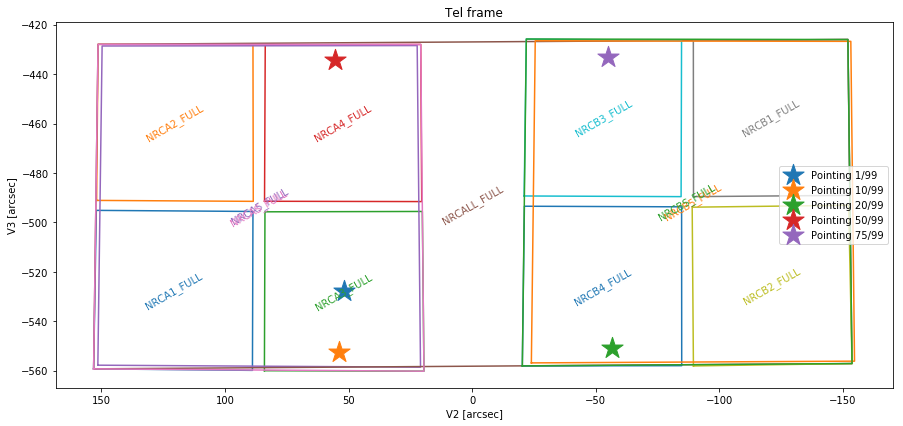

In [61]:
# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = jwxml.SIAF(filename=siaf_file)
nc_siaf.instrument = 'NIRCam'
nc_full = nc_siaf.apertures['NRCA1_FULL']

plt.figure(figsize=(15,10))
for apername in sorted(nc_siaf.apernames):
    a = apername
    if ('_FULL' in a) and ('OSS' not in a) and ('MASK' not in a) and (a[-1] != 'P'):
#         print(apername, nc_siaf.apertures[apername].V2Ref, nc_siaf.apertures[apername].V3Ref)
#         plt.scatter(nc_siaf.apertures[apername].V2Ref, nc_siaf.apertures[apername].V3Ref)
        nc_siaf.apertures[a].plot(frame='Tel')
plt.gca().invert_xaxis()

# Compare V2/V3 of targets (from .pointing file)
apt_prop = apt_inputs.AptInput()
pointing_tab = apt_prop.get_pointing_info(pointing_file, root[-4:])
all_pointings = set([(v2, v3, obs_id) for v2, v3, obs_id in zip(pointing_tab['v2'], 
                                                                pointing_tab['v3'], 
                                                                pointing_tab['observation_id'])])

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, obs_id) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, obs_id))

plt.legend()

plt.show()

It looks like pointing number 1 in the A3 detector would be a good choice (the blue star in the green left box). So, looking at the printed output, we want to use the visit file that starts with "V1140001004P000000000111q".

Note: the yaml files are named like so:

VPPPPvvvOOOEEEEEEEEEEEEEE_DD_FFFFF.yaml

where:
* V is for visit
* P is for proposal number
* v is for visit number
* O is for observation number
* E is for exposure number
* D is for detector
* F is for filter

So `V1140001004P000000000111q_A3_F212N.yaml` would be the first visit in the fourth observation of APT proposal 1140, exposure 111q, taken with the A3 detector and the F212N filter.

In [66]:
file_name_to_match = 'V1140001004P000000000111q'
yaml_to_sim = [y for y in yfiles if file_name_to_match in y][0]

# Run simulation

In [63]:
def make_sim(paramfile):
    # Create seed image
    cat = catalog_seed_image.Catalog_seed()
    cat.paramfile = paramfile
    cat.make_seed()
    print('- - - - - - - - - - SEED IMAGE CREATED - - - - - - - - - -')
    
    # Prepare dark current exposure
    d = dark_prep.DarkPrep()
    d.paramfile = paramfile
    d.prepare()
    print('- - - - - - - DARK CURRENT EXPOSURE CREATED - - - - - - -')
    
    # Combine into final observation
    obs = obs_generator.Observation()
    obs.linDark = d.prepDark
    obs.seed = cat.seedimage
    obs.segmap = cat.seed_segmap
    obs.seedheader = cat.seedinfo
    obs.paramfile = paramfile
    final_file = obs.create()
    print('- - - - - - FINAL SIMULATED EXPOSURE CREATED - - - - - -')
    
    return cat, d, obs, final_file

(We call the different parts of the simulator individually here for transparency's sake, but the `make_sim()` function is basically replicated by `mirage.imaging_simulator

In [65]:
# Make simulated image
yaml_in = os.path.join(ote_dir, yaml_to_sim)
cat, d, obs, final_file = make_sim(yaml_in)

Requested readout pattern RAPID is valid. Using the nframe = 1 and nskip = 0
No galaxy catalog provided in yaml file.
Creating signal rate image of synthetic inputs.
Point list input positions assumed to be in units of RA and Dec.
No point source catalog index numbers. Adding to output: /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/V1140001004P000000000111q_A3_F212N_uncal_pointsources.list.
After point sources, max index is 366
Expected time to process 366 sources: 0.89 seconds (0.01 minutes)
Number of point sources found within the requested aperture: 1
Seed image is 2D.
Seed image and segmentation map saved as /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/V1140001004P000000000111q_A3_F212N_uncal_F212N_seed_image.fits
Seed image, segmentation map, and metadata available as:
self.seedimage, self.seed_segmap, self.seedinfo.
- - - - - - - - - - SEED IMAGE CREATED - - - - - - - - - -
Requested readout pattern RAPID is valid. Using the 

WCS info for /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/V1140001004P000000000111q_A3_F212N_linear.fits complete.


Final linearized exposure saved to:
/Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/V1140001004P000000000111q_A3_F212N_linear.fits
Observation generation complete.
- - - - - - FINAL SIMULATED EXPOSURE CREATED - - - - - -


# Examine simulation output

In [67]:
def show(array,title,min=0,max=1000):
    plt.figure(figsize=(12,12))
    plt.imshow(array,clim=(min,max))
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04).set_label('DN$^{-}$/s')
    plt.show()

Using  /Users/lchambers/TEL/nircam_simulator/nircam_simulator/examples/ote_data/V1140001004P000000000111q_A3_F212N_linear.fits


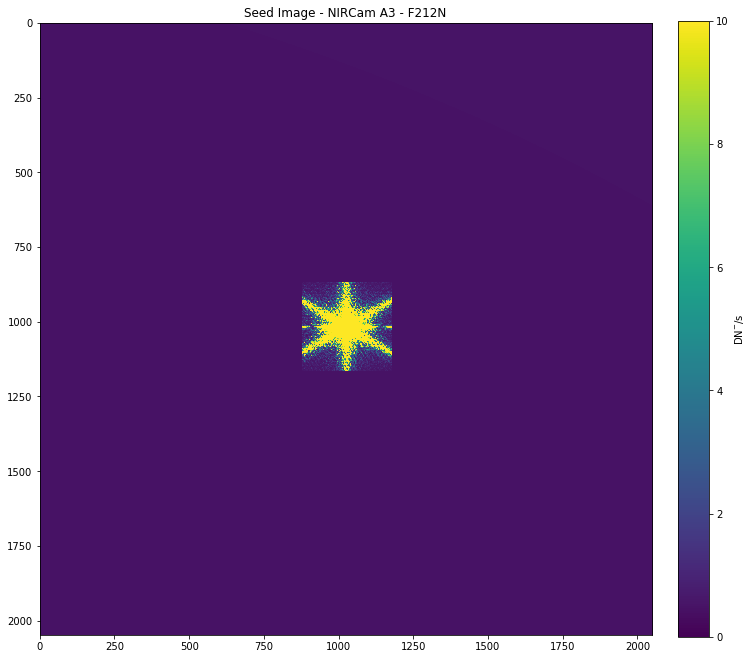

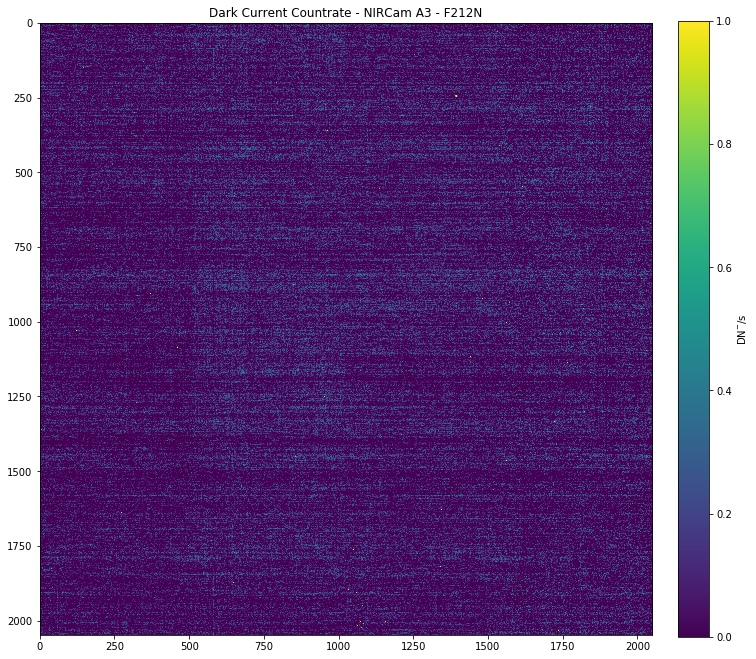

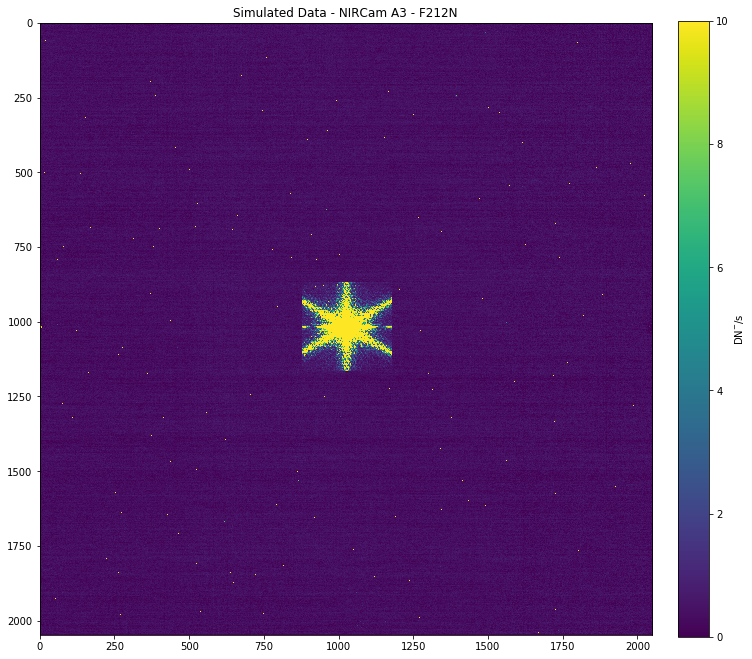

In [68]:
# Determine which FITS file to use
basename = os.path.split(yaml_in)[-1].split('.')[0]
linfile = os.path.join(ote_dir, basename + '_linear.fits')
print('Using ', linfile)

det = linfile.split('_')[-3]
filt = linfile.split('_')[-2]

# Plot seed image
show(cat.seedimage, 'Seed Image - NIRCam {} - {}'.format(det, filt), max=10)

# Plot dark current image
exptime = d.linDark.header['NGROUPS'] * cat.frametime
diff = (d.linDark.data[0,-1,:,:] - d.linDark.data[0,0,:,:]) / exptime
show(diff, 'Dark Current Countrate - NIRCam {} - {}'.format(det, filt), max=1)

# Plot final simulated image (get most recent linear.fits file)
with fits.open(linfile) as h:
    lindata = h[1].data
    header = h[0].header
exptime = header['EFFINTTM']
diffdata = (lindata[0, -1] - lindata[0, 0]) / exptime

show(diffdata, 'Simulated Data - NIRCam {} - {}'.format(det, filt), max=10) 